This notebook is apart of the IBM Data Science Capstone on Coursera. The goal is to segment and cluster different neighborhoods in Toronto. I do this by scraping web data from wikipedia about different boroughs and then access the foursquare API to explore different places within those boroughs for the cluster analysis.

**Note:** There is code commented out throught the notebook that impacts how boroughs with multiple corresponding neighborhoods select latitudes and longitudes with which to access the foursquare API. Currently, the program just selects the first neighborhood listed after the borough in the wikipedia table the data is scraped from.

In [1]:
# webscraping
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as ureq
#!conda install requests
import requests
import json

import re

# for gathering latitude and longitude
from geopy.geocoders import Nominatim

# for progress bar (latitude, longitude processing is kind of slow)
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for accessing maps
!conda install -c conda-forge folium=0.5.0 --yes
import folium

from sklearn.cluster import KMeans

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.0-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00   1.14 MB/s
branca-0.3.0-p 100% |################################| Time: 0:00:00  27.77 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  31.02 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  38.50 MB/s


In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
src = requests.get(url).text

In [3]:
soup = soup(src, 'lxml')

In [4]:
table = soup.find('table', class_='wikitable sortable')

In [5]:
ls = []
for row in table.find_all('tr'):
    col = row.find_all('td')
    if len(col) == 3:
        ls.append((col[0].text.strip(), col[1].text.strip(), col[2].text.strip()))

In [6]:
df = pd.DataFrame(np.asarray(ls))
df.columns = ['PostalCode', 'Borough', 'Neighborhood']

df['Neighborhood'] = df['Neighborhood'].str.replace(']', '')

df.replace('Not assigned', np.nan, inplace=True)

df.head(10)

,PostalCode,Borough,Neighborhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,NaN
9,M8A,NaN,NaN


Handle situations like that of index 8, PostalCode M7A by setting the neighborhood equal to the borough if there code has a borough but there is no neighborhood in the wiki table.

In [7]:
for i in range(0, len(df.index)):
    if df.iloc[i,1] is not np.nan and df.iloc[i,2] is np.nan:
        df.iloc[i,2] = df.iloc[i,1]
df.head(10)

,PostalCode,Borough,Neighborhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
9,M8A,NaN,NaN


In [8]:
df.dropna(inplace=True)
df = df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [9]:
df.shape

(103, 3)

In [10]:
lats = []
lons = []
geolocator = Nominatim(user_agent="GeocodeEarth")
with tqdm(total=len(list(df.iterrows()))) as pbar:
    for index,row in df.iterrows():
        pbar.update(1)
        # handle special case
        if row['Borough'] == "Queen's Park":
            location = geolocator.geocode("Queen's Park, Toronto")
        else:
            # only use one neighborhood to look up the lat, lon coordinates
            location = geolocator.geocode(row['Neighborhood'].split(',')[0] + 
                                              ", " + row['Borough'] + ', Toronto')
            if location == None:
                location = geolocator.geocode(row['Borough'] + ', Toronto')
        #print(index, location.address)
        lats.append(location.latitude)
        lons.append(location.longitude)
       # hood_used_indices.append(hood_used_idx)

100%|██████████| 103/103 [01:15<00:00,  1.65it/s]


In [11]:
df["Latitude"] = lats
df["Longitude"] = lons
df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.804930,-79.165837
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.790117,-79.173334
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.754899,-79.197776
3,M1G,Scarborough,Woburn,43.759824,-79.225291
4,M1H,Scarborough,Cedarbrae,43.756467,-79.226692
5,M1J,Scarborough,Scarborough Village,43.743742,-79.211632
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.707499,-79.266463
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.708823,-79.295986
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.721939,-79.236232
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.773077,-79.257774


In [12]:
location = geolocator.geocode("Toronto")
lat = location.latitude
lon = location.longitude

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[lat, lon], zoom_start=10)

# add markers to map
for lat, lon, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], 
                                           df['Neighborhood']):
    # only use the first neighborhood to label on the map
    label = '{}, {}'.format(neighborhood.split(',')[0], borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [13]:
# TEST: sample entry
index = 10
assert index < df.shape[0] # must be less than num entries in df
neighborhood_latitude = df.loc[index, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[index, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[index, 'Neighborhood'].split(',')[0] # neighborhood name
borough_name = df.loc[index, 'Borough']

print('Latitude = {} and longitude = {} for {}, {}'.format(neighborhood_latitude, 
                                                       neighborhood_longitude,
                                                       neighborhood_name,
                                                       borough_name))

Latitude = 43.7528467 and longitude = -79.282067 for Dorset Park, Scarborough


### FOURSQUARE API
* [Foursquare](https://foursquare.com/) is a company with a massive dataset of accurate and comprehensive location data that power data for Apple Maps, Uber, Snapchat, Twitter, and others. The following cells access the foursquare developer API

* The developer API gives access to user data, aggregated or individual venue data, and allows for a variety of different types of queries to the foursquare database
    * For example, when doing a search query for an individual venue the API gives access to the venue's name, unique ID, location, category, available statistics, contact information, tips, ratings, and a URL. A search query for a user may give access to first name, last name, friends on foursquare, contact info, ID, tips, and gender. 
        * Note that some of these features may requires a premium account

* The following code uses the explore endpoint to query the foursquare database and gather information on multiple venues within a specified radius of the latitude and longitude found for each borough

check out the trending endpoint

In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

venue_results = requests.get(url).json()

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
venues = venue_results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(13) # this is the size of index = 0 neighborhood

,name,categories,lat,lng
0,Starbucks,Coffee Shop,43.752496,-79.276393
1,Kim Kim restaurant,Chinese Restaurant,43.753833,-79.276611
2,Kairali,Indian Restaurant,43.754768,-79.277199
3,El Pulgarcito,Latin American Restaurant,43.754790,-79.277064
4,The Beer Store,Beer Store,43.750603,-79.276801
5,Kennedy Bowlerama,Bowling Alley,43.750512,-79.277040
6,The Fanzone Wings & Ribs,Wings Joint,43.753263,-79.276491
7,Jerry's Fish & Chips,Fish & Chips Shop,43.753717,-79.276784
8,TechDirect,Electronics Store,43.752739,-79.276562
9,White Shield Plaza,Plaza,43.750566,-79.277504


In [18]:
# print('{} venues were returned by Foursquare in {}'.format(nearby_venues.shape[0], neighborhood_name[hood_used_indices[index]].strip()))
print('{} venues were returned by Foursquare in {}'.format(nearby_venues.shape[0], neighborhood_name))

12 venues were returned by Foursquare in Dorset Park


In [19]:
def getNearbyVenues(names, indices, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, hood_used_idx, lat, lng in zip(names, indices, latitudes, longitudes):
        name = name[hood_used_idx].strip()
        # print(name) 
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for names, lat, lng in zip(names, latitudes, longitudes):
        
        name = names.split(',')[0]
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # print(name)
        
        # handle empty requests
        if results == []:
            venues_list.append([(
            name, 
            lat, 
            lng, 
            None, 
            None, 
            None,  
            None)])
        
        else: 
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return nearby_venues

In [21]:
venues = getNearbyVenues(names=df['Neighborhood'],
                         latitudes=df['Latitude'],
                         longitudes=df['Longitude'])

In [25]:
# TEST
# check sizes match for num unique neighborhoods
assert venues['Neighborhood'].nunique() == df['Neighborhood'].nunique()

In [26]:
# TEST: first neighborhood in df should match the neighborhood used to look up venues
# to see which boroughs (if any) are causing problems
v=venues['Neighborhood'].unique()
d=df['Neighborhood'].unique()
for i in range(90,100):
    print(d[i], ' | ', v[i])

The Kingsway, Montgomery Road, Old Mill North  |  The Kingsway
Humber Bay, King's Mill Park, Kingsway Park South East, Mimico NE, Old Mill South, The Queensway East, Royal York South East, Sunnylea  |  Humber Bay
Kingsway Park South West, Mimico NW, The Queensway West, Royal York South West, South of Bloor  |  Kingsway Park South West
Islington Avenue  |  Islington Avenue
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park  |  Cloverdale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe  |  Bloordale Gardens
Humber Summit  |  Humber Summit
Emery, Humberlea  |  Emery
Weston  |  Weston
Westmount  |  Westmount


In [28]:
print(venues.shape, venues['Neighborhood'].nunique())
venues.head()

(3398, 7) 103


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rouge,43.804930,-79.165837,Dean Park,43.804364,-79.169159,Park
1,Rouge,43.804930,-79.165837,Paul's Breakfast & Burgers,43.803835,-79.169825,Fast Food Restaurant
2,Highland Creek,43.790117,-79.173334,Highland Creek,43.790281,-79.173703,Neighborhood
3,Guildwood,43.754899,-79.197776,Guildwood GO Station,43.754977,-79.198372,Train Station
4,Guildwood,43.754899,-79.197776,Via. Rail 651,43.755331,-79.197072,Moving Target


In [29]:
print('There are {} unique venue categories'.format(len(venues['Venue Category'].unique())))

There are 236 unique venue categories


In [30]:
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
print(onehot.shape)
onehot.head()

(3398, 236)


,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + list(onehot.drop('Neighborhood', axis=1).columns)
onehot = onehot[fixed_columns]

print(onehot.shape)
onehot.head()

(3398, 236)


,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Rouge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rouge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Highland Creek,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Guildwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Guildwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Compute the occurence frequency of each venue type in each neighborhood

In [32]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
print(grouped.shape)
grouped.head()

(103, 236)


,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,...,0.0,0.01,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.076923,0.0,0.0,0.000000,0.0,0.0
2,Agincourt North,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.032258,0.0,0.032258,0.0,0.0,0.032258,0.0,0.0
3,Albion Gardens,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,Alderwood,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [33]:
num_top_venues = 5
num2print = 5

for hood in grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    num2print -= 1
    if num2print <= 0:
        break

----Adelaide----
                 venue  freq
0          Coffee Shop  0.07
1       Clothing Store  0.06
2           Restaurant  0.06
3  American Restaurant  0.04
4                 Café  0.04


----Agincourt----
                   venue  freq
0       Asian Restaurant  0.23
1     Chinese Restaurant  0.23
2            Coffee Shop  0.08
3  Vietnamese Restaurant  0.08
4   Cantonese Restaurant  0.08


----Agincourt North----
                  venue  freq
0        Ice Cream Shop  0.06
1    Chinese Restaurant  0.06
2  Fast Food Restaurant  0.06
3                Bakery  0.06
4           Supermarket  0.03


----Albion Gardens----
                  venue  freq
0          Dessert Shop   1.0
1     Accessories Store   0.0
2  Pakistani Restaurant   0.0
3   Monument / Landmark   0.0
4         Movie Theater   0.0


----Alderwood----
          venue  freq
0   Pizza Place  0.25
1  Dance Studio  0.12
2           Gym  0.12
3          Bank  0.12
4   Coffee Shop  0.12




In [148]:
def return_most_common_venues(row, num_top_venues):
    """sort venues in descending order"""
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # if the sorted frequencies have a zero before the number of venues
    # we want to return, we will fill those cells with 'NONE' so that we 
    # are not arbitrarily selecting venue types 
    zero_occurence_threshold = -1
    for i in range(num_top_venues):
        if row_categories_sorted[i] < 1e-7:
            zero_occurence_threshold = i
            break
    
    ret_val = np.array([])
    if zero_occurence_threshold == -1:  # there are 10 non-zero venue types
        ret_val = row_categories_sorted.index.values[0:num_top_venues]
    else:
        ret_val = row_categories_sorted.index.values[0:zero_occurence_threshold]
        for i in range(zero_occurence_threshold, num_top_venues):
            ret_val = np.append(ret_val, "NONE")
    
    return ret_val

In [150]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Clothing Store,Restaurant,American Restaurant,Café,Tea Room,Cosmetics Shop,Burger Joint,Gastropub,Food Court
1,Agincourt,Chinese Restaurant,Asian Restaurant,Train Station,Cantonese Restaurant,Electronics Store,Coffee Shop,Korean Restaurant,Vietnamese Restaurant,Hong Kong Restaurant,NONE
2,Agincourt North,Ice Cream Shop,Bakery,Fast Food Restaurant,Chinese Restaurant,Clothing Store,Beer Store,Sporting Goods Shop,Spa,Shopping Mall,Sandwich Place
3,Albion Gardens,Dessert Shop,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,Alderwood,Pizza Place,Dance Studio,Pub,Sandwich Place,Gym,Coffee Shop,Bank,NONE,NONE,NONE


In [151]:
grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,Art Museum,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,...,0.0,0.01,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.076923,0.0,0.0,0.000000,0.0,0.0
2,Agincourt North,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.032258,0.0,0.032258,0.0,0.0,0.032258,0.0,0.0
3,Albion Gardens,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,Alderwood,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


### CLUSTER ANALYSIS

Now that the data is processed into an occurence frequency table for each neighborhood and venue type, we can run a clustering algorithm to find structure in the data and sort like types of neighborhoods together. The next cell will run the K-means clustering algorithms, which partitions the data into k clusters by repeating the process of choosing a centroid for each cluster, finding the distance from each point to each cluster, assigning that point to the closest cluster, and then relocating each centroid (cluster center) by taking the mean of all data points assigned to that cluster at the current iteration. This will be done for a specified amount of k values so we can plot them and see what may be a good k value to select. 

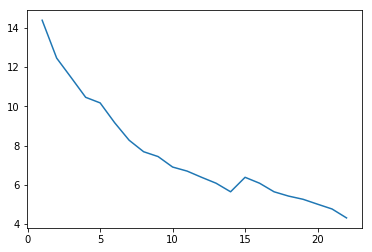

In [165]:
# set number of clusters
max_clusters = 20

grouped_clustering = grouped.drop('Neighborhood', 1)

# within cluster some of squares
wcss = []

for k in range(12, max_clusters):

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(grouped_clustering)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,max_clusters), wcss)

### SELECTING K

The metric we want to optimize is a minimization of the within cluster some of squares (i.e. variance), which corresponds to maximizing the between-cluster sum of squares. In the graph above it looks like the within cluster sum of squares is reaching a point of diminishing returns around 10-14, so I will choose 12 as the k-value.

[0 0 0 0 0 3 0 2 0 0 3 0 1 0 0 0 4 0 0 0 0 0 0 0 1 0 0 0 0 0 0 4 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 4 0 1 0 0 0 0 3 0 1 0 1 0 1 0 1 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 4]


(array([ 80.,   0.,  15.,   0.,   0.,   1.,   0.,   3.,   0.,   4.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

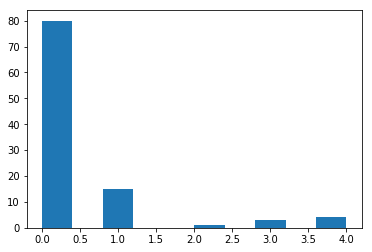

In [210]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_) 

plt.hist(kmeans.labels_)

In [211]:
# get the first neighborhood for each 
df['Neighborhood'] = df['Neighborhood'].apply(lambda x: x.split(',')[0])

In [212]:
merged = df.groupby("Neighborhood").mean().reset_index() 

# add clustering labels
merged['Cluster Label'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,43.654027,-79.380200,0,Coffee Shop,Clothing Store,Restaurant,American Restaurant,Café,Tea Room,Cosmetics Shop,Burger Joint,Gastropub,Food Court
1,Agincourt,43.785353,-79.278549,0,Chinese Restaurant,Asian Restaurant,Train Station,Cantonese Restaurant,Electronics Store,Coffee Shop,Korean Restaurant,Vietnamese Restaurant,Hong Kong Restaurant,NONE
2,Agincourt North,43.808038,-79.266439,0,Ice Cream Shop,Bakery,Fast Food Restaurant,Chinese Restaurant,Clothing Store,Beer Store,Sporting Goods Shop,Spa,Shopping Mall,Sandwich Place
3,Albion Gardens,43.750011,-79.637342,0,Dessert Shop,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,Alderwood,43.601717,-79.545232,0,Pizza Place,Dance Studio,Pub,Sandwich Place,Gym,Coffee Shop,Bank,NONE,NONE,NONE


In [213]:
# create map
location = geolocator.geocode("Toronto")
lat = location.latitude
lon = location.longitude

map_clusters = folium.Map(location=[lat, lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### CLUSTER ANALYSIS

In [214]:
merged['Cluster Label'].value_counts()

0    80
1    15
4     4
3     3
2     1
Name: Cluster Label, dtype: int64

In [215]:
merged.loc[merged['Cluster Label'] == 0, merged.columns[[0] + list(range(3, merged.shape[1]))]].head(10)

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,0,Coffee Shop,Clothing Store,Restaurant,American Restaurant,Café,Tea Room,Cosmetics Shop,Burger Joint,Gastropub,Food Court
1,Agincourt,0,Chinese Restaurant,Asian Restaurant,Train Station,Cantonese Restaurant,Electronics Store,Coffee Shop,Korean Restaurant,Vietnamese Restaurant,Hong Kong Restaurant,NONE
2,Agincourt North,0,Ice Cream Shop,Bakery,Fast Food Restaurant,Chinese Restaurant,Clothing Store,Beer Store,Sporting Goods Shop,Spa,Shopping Mall,Sandwich Place
3,Albion Gardens,0,Dessert Shop,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,Alderwood,0,Pizza Place,Dance Studio,Pub,Sandwich Place,Gym,Coffee Shop,Bank,NONE,NONE,NONE
6,Bayview Village,0,Pizza Place,Coffee Shop,Breakfast Spot,Sporting Goods Shop,Fish Market,Gas Station,Fast Food Restaurant,Sandwich Place,Outdoor Supply Store,Bank
8,Berczy Park,0,Coffee Shop,Clothing Store,Restaurant,American Restaurant,Café,Tea Room,Cosmetics Shop,Burger Joint,Gastropub,Food Court
9,Birch Cliff,0,Clothing Store,Coffee Shop,Cosmetics Shop,Food Court,Tea Room,Sandwich Place,Restaurant,Sporting Goods Shop,Smoothie Shop,Shopping Mall
11,Brockton,0,Vietnamese Restaurant,Bar,Café,Park,Grocery Store,Portuguese Restaurant,South American Restaurant,Gastropub,Bakery,Coffee Shop
13,CFB Toronto,0,Ramen Restaurant,Coffee Shop,Korean Restaurant,Restaurant,Japanese Restaurant,Pizza Place,Sandwich Place,Café,Steakhouse,Bubble Tea Shop


In [216]:
merged.loc[merged['Cluster Label'] == 1, merged.columns[[0] + list(range(3, merged.shape[1]))]].head(5)

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Business reply mail Processing Centre969 Eastern,1,Park,Light Rail Station,Gym / Fitness Center,American Restaurant,Building,Trail,Lake,Bus Stop,NONE,NONE
24,Clarks Corners,1,Caribbean Restaurant,Park,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
45,Forest Hill North,1,Park,Light Rail Station,Gym / Fitness Center,American Restaurant,Building,Trail,Lake,Bus Stop,NONE,NONE
51,High Park,1,Park,Light Rail Station,Gym / Fitness Center,American Restaurant,Building,Trail,Lake,Bus Stop,NONE,NONE
56,Humber Summit,1,Bakery,Park,Empanada Restaurant,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [220]:
merged.loc[merged['Cluster Label'] == 2, merged.columns[[0] + list(range(3, merged.shape[1]))]].head(5)

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Bedford Park,2,Locksmith,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [221]:
merged.loc[merged['Cluster Label'] == 3, merged.columns[[0] + list(range(3, merged.shape[1]))]].head(5)

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Bathurst Manor,3,Playground,Convenience Store,Park,Baseball Field,NONE,NONE,NONE,NONE,NONE,NONE
10,Bloordale Gardens,3,Convenience Store,Sandwich Place,Deli / Bodega,Intersection,Park,Shipping Store,NONE,NONE,NONE,NONE
64,Leaside,3,Sandwich Place,Convenience Store,Japanese Restaurant,Park,NONE,NONE,NONE,NONE,NONE,NONE


In [222]:
merged.loc[merged['Cluster Label'] == 4, merged.columns[[0] + list(range(3, merged.shape[1]))]].head(5)

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Caledonia-Fairbanks,4,Turkish Restaurant,Coffee Shop,Sandwich Place,Grocery Store,Wine Shop,NONE,NONE,NONE,NONE,NONE
31,Del Ray,4,Turkish Restaurant,Coffee Shop,Sandwich Place,Grocery Store,Wine Shop,NONE,NONE,NONE,NONE,NONE
57,Humewood-Cedarvale,4,Turkish Restaurant,Coffee Shop,Sandwich Place,Grocery Store,Wine Shop,NONE,NONE,NONE,NONE,NONE
102,York Mills West,4,Wine Shop,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [198]:
merged.loc[merged['Cluster Label'] == 5, merged.columns[[0] + list(range(3, merged.shape[1]))]].head(5)

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Bedford Park,5,Locksmith,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [199]:
merged.loc[merged['Cluster Label'] == 6, merged.columns[[0] + list(range(3, merged.shape[1]))]].head(5)

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
93,Upper Rouge,6,Trail,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [201]:
merged.loc[merged['Cluster Label'] == 7, merged.columns[[0] + list(range(3, merged.shape[1]))]].head(5)

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Albion Gardens,7,Dessert Shop,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [206]:
merged.loc[merged['Cluster Label'] == 8, merged.columns[[0] + list(range(3, merged.shape[1]))]].head(5)

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Caledonia-Fairbanks,8,Turkish Restaurant,Coffee Shop,Sandwich Place,Grocery Store,Wine Shop,NONE,NONE,NONE,NONE,NONE
31,Del Ray,8,Turkish Restaurant,Coffee Shop,Sandwich Place,Grocery Store,Wine Shop,NONE,NONE,NONE,NONE,NONE
57,Humewood-Cedarvale,8,Turkish Restaurant,Coffee Shop,Sandwich Place,Grocery Store,Wine Shop,NONE,NONE,NONE,NONE,NONE
75,Queen's Park,8,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Ice Cream Shop,Park,Japanese Restaurant,Indian Restaurant,French Restaurant,Smoothie Shop
81,Scarborough Village,8,Coffee Shop,Supermarket,Fast Food Restaurant,Chinese Restaurant,Gym,Shopping Mall,Pub,NONE,NONE,NONE


In [203]:
merged.loc[merged['Cluster Label'] == 9, merged.columns[[0] + list(range(3, merged.shape[1]))]].head(5)

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Canada Post Gateway Processing Centre,9,Airport Terminal,Airport,Accessories Store,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [204]:
merged.loc[merged['Cluster Label'] == 10, merged.columns[[0] + list(range(3, merged.shape[1]))]].head(5)

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
59,Kingsview Village,10,Construction & Landscaping,Park,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
66,Maple Leaf Park,10,Bakery,Construction & Landscaping,Business Service,Park,NONE,NONE,NONE,NONE,NONE,NONE
72,Northwood Park,10,Food Truck,Construction & Landscaping,Park,Baseball Field,NONE,NONE,NONE,NONE,NONE,NONE


In [205]:
merged.loc[merged['Cluster Label'] == 11, merged.columns[[0] + list(range(3, merged.shape[1]))]].head(5)

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,Westmount,11,Pizza Place,Park,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
